In [7]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy

np.set_printoptions(precision=3, suppress=True)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv("./auto-mpg.data", names=column_names,
                            na_values='?', comment='\t',
                            sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
# Turn last 0/1/2 categorical column in 3 binary columns:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
# dataset.tail()

In [8]:
# Split dataset into training and testing
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

x = train_features.to_numpy()
y = train_labels.to_numpy()
x_test = test_features.to_numpy()
y_test = test_labels.to_numpy()


In [9]:
# See dataset "clouds"
# sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')


1. DNN:

In [10]:
def build_and_compile_model(norm, layers=[64, 64]):
    l = [norm]
    for units in layers:
        l.append(tf.keras.layers.Dense(units=units, activation='relu'))
    l.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(l)
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.001)
    )
    return model


def polynom(inputs: np.ndarray, degree=1):
    assert degree > 0
    if degree == 1:
        return inputs

    transposed = inputs.T
    base = len(transposed)

    pols = []
    newgen = []
    for i in range(base):
        newgen.append([i])
    pols.extend(newgen)

    for deg in range(1, degree):
        lastgen = newgen
        newgen = []
        for p in lastgen:
            for i in range(p[-1], base):
                pnext = [*p, i]
                pnext.sort()
                newgen.append(pnext)
        pols.extend(newgen)

    new_inputs = []
    for p in pols:
        new_inputs.append(deepcopy(transposed[p[0]]))
        for i in p[1:]:
            new_inputs[-1] *= transposed[i]
    return np.array(new_inputs).T


def plot_loss(history: tf.keras.callbacks.History):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)


def fit_with_params(degree=1, layers=[64, 64]):
    xd = polynom(x, degree=degree)
    norm = tf.keras.layers.Normalization(axis=-1)
    norm.adapt(xd)
    net = build_and_compile_model(norm=norm, layers=layers)
    history: tf.keras.callbacks.History = net.fit(
        xd,
        y,
        validation_split=0.2,
        verbose=0, epochs=100)
    xd_test = polynom(x_test, degree=degree)
    mae: float = net.evaluate(xd_test, y_test, verbose=0)
    return history, mae


def plot_losses(histories: list[tf.keras.callbacks.History], titles: list | None = None, append=None):
    amount_of_graphs = len(histories)
    if append is not None:
        amount_of_graphs += 1
    fig = plt.figure(figsize=(amount_of_graphs*6, 5))
    gs = fig.add_gridspec(1, amount_of_graphs)  # hspace=0, wspace=0)
    a = gs.subplots()
    for i in range(len(histories)):
        ax = a if amount_of_graphs == 1 else a[i]
        ax.plot(histories[i].history['loss'], label='loss')
        ax.plot(histories[i].history['val_loss'], label='val_loss')
        ax.set_ylim(0, 4)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Error [MPG]')
        ax.legend()
        ax.grid(True)
        if titles is not None:
            ax.set_title(titles[i])
    if append is not None:
        ax = a[-1]
        ax.plot(append[0], label="losses")
        ax.plot(append[1], label="val_losses")
        ax.plot(append[2], label="maes")
        ax.legend()
        ax.grid(True)
    plt.show()


In [75]:
def try_degrees(layers=[64,64], degrees=[1,2,3,4], plot=True):
    hists = []
    losses = []
    val_losses = []
    maes = []
    for degree in degrees:
        hist,mae = fit_with_params(degree=degree,layers=layers)
        hists.append(hist)
        losses.append(hist.history['loss'][-1])
        val_losses.append(hist.history['val_loss'][-1])
        maes.append(mae)
    if plot:
        if len(degrees) > 1:
            plot_losses(hists, maes, append=[losses,val_losses,maes])
        else:
            plot_losses(hists, maes)
    return hists,losses,val_losses,maes


rng = list(range(50,110, 10))
results_l = np.zeros((len(rng), len(rng)))
results_vl = np.zeros((len(rng), len(rng)))
for i in range(len(rng)):
    for j in range(len(rng)):
        l1 = rng[i]
        l2 = rng[j]
        print(f"{l1}:{l2}...")
        h,l,vl,e = try_degrees([l1,l2],[1],plot=False)
        results_l[i,j] = l[0]
        results_vl[i,j] = vl[0]



50:50...
50:60...
50:70...
50:80...
50:90...
50:100...
60:50...
60:60...
60:70...
60:80...
60:90...
60:100...
70:50...
70:60...
70:70...
70:80...
70:90...
70:100...
80:50...
80:60...
80:70...
80:80...
80:90...
80:100...
90:50...
90:60...
90:70...
90:80...
90:90...
90:100...
100:50...
100:60...
100:70...
100:80...
100:90...
100:100...


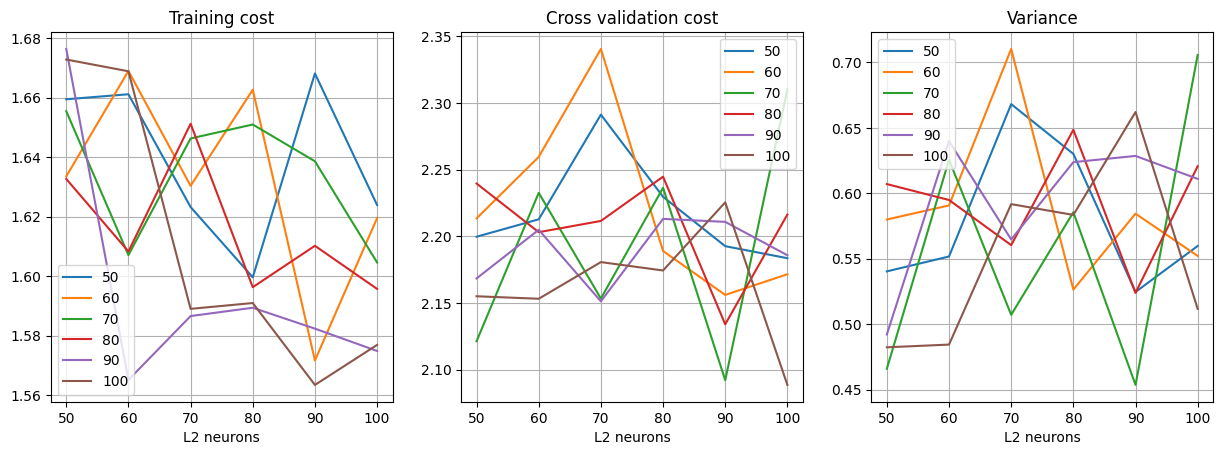

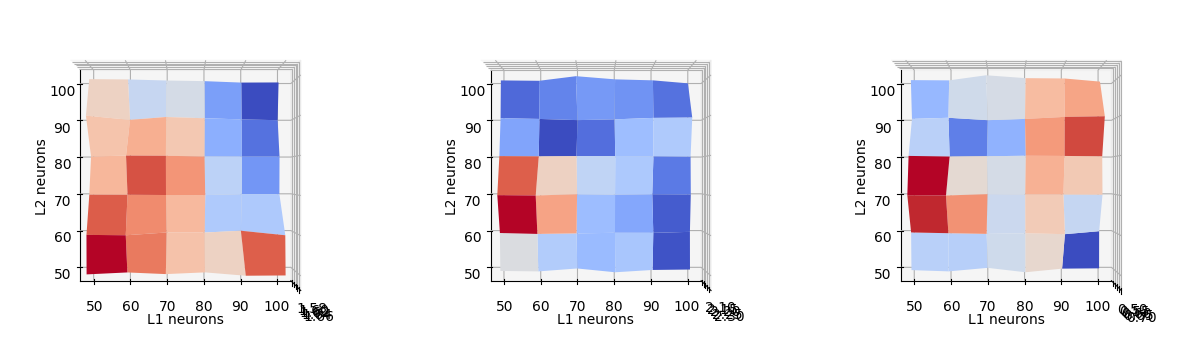

In [76]:
from matplotlib import cm
# print(results_l)
# print(results_vl)
results_variance = results_vl - results_l
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for ax, res, title in zip(axs, [results_l, results_vl, results_variance], ["Training cost", "Cross validation cost", "Variance"]):
    for i, rl in enumerate(res):
        ax.plot(rng, rl, label=f"{rng[i]}")
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("L2 neurons")
    ax.grid()
plt.show()

fig, axs = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
fig.set_figwidth(15)
for ax, res, title in zip(axs, [results_l, results_vl, results_variance], ["Training cost", "Cross validation cost", "Variance"]):
    ax.view_init(azim=0, elev=90)
    X, Y = np.meshgrid(rng, rng)
    ax.invert_xaxis()
    ax.set_xlabel("L2 neurons")
    ax.set_ylabel("L1 neurons")
    surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    # for i, rl in enumerate(res):
    #     ax.plot(rng, rl, label=f"{rng[i]}")
    # ax.legend()
    # ax.set_title(title)
    # ax.set_xlabel("L2 neurons")
    # ax.grid()
plt.show()
